In [1]:
import pandas as pd
import glob
import sys
sys.path.insert(1, '..')
from src import readfiles
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms

# **Warning:**
# Files named 001 and 002 do not always correspond to the same crystal!
# So this information must be extracted from the metadata.
# So get all the data into one big list!

def read_scans_and_split_by_xtl(allfolders):

    data_list = []
    metadata_list = []

    for i in range(len(allfolders)):
        _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                             'data001_mm.csv', 'data001.cnd',
                                                             comment_line_num=80,
                                                             return_metadata=True)
        data_list.append(data)
        metadata_list.append(metadata)

        if (Path(allfolders[i]) / Path("data002_mm.csv")).exists():
            _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                                'data002_mm.csv', 'data002.cnd',
                                                                comment_line_num=80,
                                                                return_metadata=True)
            data_list.append(data)
            metadata_list.append(metadata)
    
    # And then split based on crystal, and save to 'cleaned_data' folder.
    
    xtls = list(set([m.crystal for m in metadata_list])) # Find the unique crystals
    data_by_xtl = {}

    for xtl in xtls:
        data_by_xtl[xtl] = []

        for i, m in enumerate(metadata_list):
            if m.crystal == xtl:
                data_by_xtl[xtl].append(data_list[i])


    return data_by_xtl

def average_spectra(data):

    """ data = a list of pandas dataframes """

    # Rehape data into np arrays
    cpsdata = np.empty(shape=(len(data[0].cps), len(data)))
    cps_per_nA_data = np.empty(shape=(len(data[0].cps), len(data)))
    Ldata = np.empty(shape=(len(data[0].L), len(data)))

    for i in range(len(data)):
        cpsdata[:, i] = data[i].cps
        cps_per_nA_data[:,i] = data[i].cps_per_nA
        Ldata[:, i] = data[i].L

    # Check L-axes are the same:
    L_axis_check = np.array([Ldata[:,n] == Ldata[:,0]
                             for n in range(len(data))])


    if L_axis_check.all().all() == False:
        print(Ldata[1:10, :])
        raise Exception('L values are not the same between datasets!')

    # Average the data
    mean_df = pd.DataFrame({'L': Ldata[:,0],
                            'cps': cpsdata.mean(axis=1),
                            'cps_per_nA': cps_per_nA_data.mean(axis=1),
                            'cps_per_nA_stdev': cps_per_nA_data.std(axis=1)})

    return mean_df

# Compile the ANU data and save

In [2]:
budd_folders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_ANU/Buddingtonite/*'))
budd_data = read_scans_and_split_by_xtl(budd_folders)
budd_avg = {'LDE1': average_spectra(budd_data['LDE1']),
             'LDE1H': average_spectra(budd_data['LDE1H'])}

In [3]:
glass_folders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_ANU/GlassA870/*'))
glass_data = read_scans_and_split_by_xtl(glass_folders)
glass_avg = {'LDE1': average_spectra(glass_data['LDE1']),
             'LDE1H': average_spectra(glass_data['LDE1H'])}

In [4]:
nitride_folders = [f for f in list(Path("../data/raw/peak_shapes/raw_data_ANU/").glob("*")) if f.stem in ["AlN", "GaN", "BN", "Si3N4"]]
nitride_names = [Path(n).stem for n in nitride_folders]
nitride_data = read_scans_and_split_by_xtl(nitride_folders)

In [5]:
for xtl in ['LDE1', 'LDE1H']:

    # Check if folder exists, if not, create it
    output_folder = Path(f'../data/interim/peak_shapes/cleaned_data_ANU/{xtl}/')
    
    if not output_folder.exists():
        output_folder.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(nitride_data[xtl])):
        nitride_data[xtl][i].to_csv(output_folder / Path(nitride_names[i] + '.csv'))
    
    budd_avg[xtl].to_csv(output_folder / Path('Buddingtonite.csv'))
    glass_avg[xtl].to_csv(output_folder / Path('GlassA870.csv'))


In [6]:
budd_longscan = read_scans_and_split_by_xtl([Path("../data/raw/peak_shapes/raw_data_ANU/budd_long_bg_scan/")])
budd_longscan

{'LDE1H': [          L  counts    cps  cps_per_nA
  0    120.00   820.0  820.0    8.191808
  1    120.08   816.0  816.0    8.151848
  2    120.16   790.0  790.0    7.892108
  3    120.24   780.0  780.0    7.792208
  4    120.32   791.0  791.0    7.902098
  ..      ...     ...    ...         ...
  746  179.68    48.0   48.0    0.479520
  747  179.76    44.0   44.0    0.439560
  748  179.84    41.0   41.0    0.409590
  749  179.92    38.0   38.0    0.379620
  750  180.00    42.0   42.0    0.419580
  
  [751 rows x 4 columns]]}

In [7]:
_, _, budd_long_metadata = readfiles.import_jeol_wdscans(
    Path("../data/raw/peak_shapes/raw_data_ANU/budd_long_bg_scan/"),
    "data001_mm.csv",
    "data001.cnd",
    comment_line_num=80,
    return_metadata=True,
)

_, _, budd_short_metadata = readfiles.import_jeol_wdscans(
    Path("../data/raw/peak_shapes/raw_data_ANU/Buddingtonite/Pos_0005/"),
    "data001_mm.csv",
    "data001.cnd",
    comment_line_num=80,
    return_metadata=True,
)


In [8]:
budd_short_metadata

folder             ..\data\raw\peak_shapes\raw_data_ANU\Buddingto...
comment                                                            0
current_nA                                                      10.0
dwell_time_s                                                    0.15
accumulations                                                      1
num_points                                                       401
total_time_mins                                                    1
crystal                                                         LDE1
step_size_um                                                   100.0
dtype: object

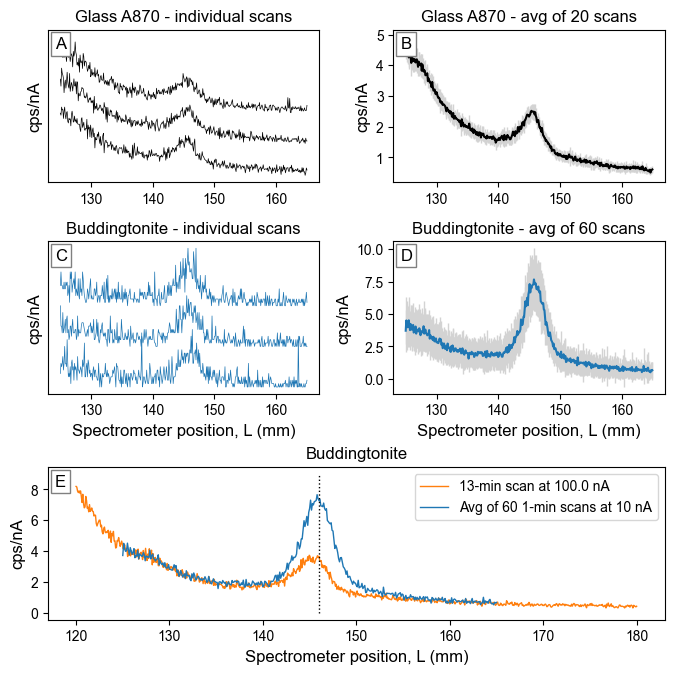

In [9]:
mosaic = """
    AB
    CD
    EE
    """

fig = plt.figure(constrained_layout=True, figsize=(17*0.39, 17*0.39))
ax_dict = fig.subplot_mosaic(mosaic)

for i in range(3):
    ax_dict["A"].plot(glass_data["LDE1H"][i].L
           , glass_data["LDE1H"][i].cps_per_nA + i*2
           , linestyle='-', color='k', lw=0.5)
    
for i in range(3):
    ax_dict["C"].plot(budd_data["LDE1H"][i].L
           , budd_data["LDE1H"][i].cps_per_nA + i*8
           , linestyle='-', color='tab:blue', lw=0.5)
    
ax_dict["B"].errorbar(x=glass_avg["LDE1H"].L
                    , y=glass_avg["LDE1H"].cps_per_nA
                    , yerr=glass_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="k"
                    )

ax_dict["D"].errorbar(x=budd_avg["LDE1H"].L
                    , y=budd_avg["LDE1H"].cps_per_nA
                    , yerr=budd_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="tab:blue"
                    )

# ADD THE LONGSCAN BACK IN HERE!! (AND UNCOMMENT SUBPLOT E STUFF BELOW)
budd_longscan["LDE1H"][0].plot(x='L', y='cps_per_nA', ax=ax_dict["E"], color="tab:orange", lw=1)
budd_avg["LDE1H"].plot(x='L', y='cps_per_nA', ax=ax_dict["E"], color="tab:blue", lw=1)

# Annotate axes -------------------------------------------------
for k, ax in ax_dict.items():
    ax.set_ylabel('cps/nA')
    ax.set_xlabel('Spectrometer position, L (mm)')
    
ax_dict["E"].plot([146,146], [0,9], ':k', lw=1)
ax_dict["E"].legend([f'{budd_long_metadata.total_time_mins}-min scan at {round(budd_long_metadata.current_nA, 0)} nA',
                     f'Avg of 60 {budd_short_metadata.total_time_mins}-min scans at {round(budd_short_metadata.current_nA)} nA'])

ax_dict["A"].set_title("Glass A870 - individual scans")
ax_dict["B"].set_title("Glass A870 - avg of 20 scans")
ax_dict["C"].set_title("Buddingtonite - individual scans")
ax_dict["D"].set_title("Buddingtonite - avg of 60 scans")
ax_dict["E"].set_title("Buddingtonite")

for label, ax in ax_dict.items():
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=12, verticalalignment='top', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))

# fig.align_labels()

ax_dict["A"].set_yticks([])
ax_dict["C"].set_yticks([])

# hack to increase space beneath top two axes
ax_dict["A"].set_xlabel(" ", fontsize=1)
ax_dict["B"].set_xlabel(" ", fontsize=1)

# plt.savefig("../figures/Budd_and_Glass_scans.png")
# plt.savefig("../figures/Figure_6.pdf", dpi=600)

plt.show()


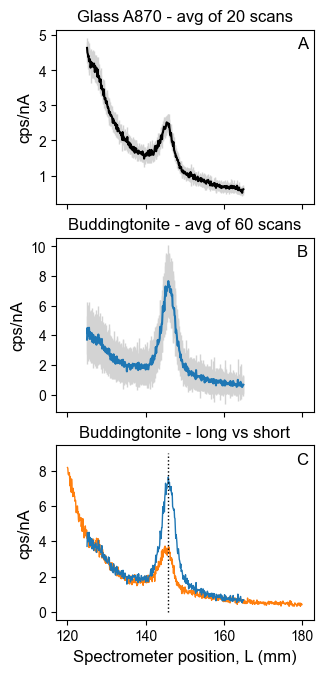

In [10]:
mosaic = """
    A
    B
    C
    """

fig = plt.figure(constrained_layout=True, figsize=(8*0.39, 17*0.39))
ax_dict = fig.subplot_mosaic(mosaic, sharex=True)

ax_dict["A"].errorbar(x=glass_avg["LDE1H"].L
                    , y=glass_avg["LDE1H"].cps_per_nA
                    , yerr=glass_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="k"
                    )

ax_dict["B"].errorbar(x=budd_avg["LDE1H"].L
                    , y=budd_avg["LDE1H"].cps_per_nA
                    , yerr=budd_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="tab:blue"
                    )

# ADD THE LONGSCAN BACK IN HERE!! (AND UNCOMMENT SUBPLOT E STUFF BELOW)
budd_longscan["LDE1H"][0].plot(x='L', y='cps_per_nA', ax=ax_dict["C"], color="tab:orange", lw=1)
budd_avg["LDE1H"].plot(x='L', y='cps_per_nA', ax=ax_dict["C"], color="tab:blue", lw=1)

# Annotate axes -------------------------------------------------
for k, ax in ax_dict.items():
    ax.set_ylabel('cps/nA')
    ax.set_xlabel('Spectrometer position, L (mm)')
    
ax_dict["C"].plot([145.7,145.7], [0,9], ':k', lw=1)
ax_dict["C"].legend([f'{budd_long_metadata.total_time_mins}-min scan at {round(budd_long_metadata.current_nA, 0)} nA',
                     f'Avg of 60 {budd_short_metadata.total_time_mins}-min scans at {round(budd_short_metadata.current_nA)} nA'])

ax_dict["A"].set_title("Glass A870 - avg of 20 scans")
ax_dict["B"].set_title("Buddingtonite - avg of 60 scans")
ax_dict["C"].set_title("Buddingtonite - long vs short")

for label, ax in ax_dict.items():
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.95, 1, label, transform=ax.transAxes + trans,
            fontsize=12, verticalalignment='top', horizontalalignment="right", fontfamily='Arial'
            # , bbox=dict(facecolor='w', edgecolor='grey', pad=3.0)
            )
    
ax.get_legend().remove()

# fig.align_labels()
# ax_dict["A"].set_yticks([])
# ax_dict["C"].set_yticks([])

# hack to increase space beneath top two axes
ax_dict["A"].set_xlabel(" ", fontsize=1)
ax_dict["B"].set_xlabel(" ", fontsize=1)

plt.savefig("../figures/Budd_and_Glass_scans.png")
plt.savefig("../figures/for_submission/Figure_6.pdf", dpi=600)

plt.show()


# Compile the StA data and save

In [11]:
allfolders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_StA/*'))

names = [Path(n).stem for n in allfolders]
data = read_scans_and_split_by_xtl(allfolders)

for xtl in data.keys():

    # Check if folder exists, if not, create it
    output_folder = Path(f'../data/interim/peak_shapes/cleaned_data_StA/{xtl}/')
    
    if not output_folder.exists():
        output_folder.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(data[xtl])):
        data[xtl][i].to_csv(output_folder / Path(names[i] + '.csv'))
